In [15]:
import sys
import numpy as np
from matplotlib import pyplot as plt

use_devel = True

# insert the mymujoco path for TrainDQN.py file
if use_devel:
  sys.path.insert(0, "/home/luke/mujoco-devel/rl")
else:
  sys.path.insert(0, "/home/luke/mymujoco/rl")

# create modelsaver instance
from ModelSaver import ModelSaver
directory = ""#"pb4_tests_apr23" # ""
saver = ModelSaver(f"test_data/{directory}", root="/home/luke/gripper-ros/")

from grasp_test_data import GraspTestData, set_palm_frc_threshold, set_X_frc_threshold, set_Y_frc_threshold
data_explorer = GraspTestData()

# enter folder and load test data
test_name = "pb1_E2_S3_YCB"
# test_name = "YCB_heuristic"
saver.enter_folder(test_name)
try:
  testdata = saver.load(id=None, filenamestarts="test_data", suffix_numbering=True)
  set_palm_frc_threshold(10.0)
  set_X_frc_threshold(10.0)
  set_Y_frc_threshold(10.0)
  data_explorer.add_palm_start_force = False
  print(data_explorer.get_test_string(data=testdata, detailed=2))

  # set_palm_frc_threshold(3.0)
  # print(data_explorer.get_test_string(data=testdata, detailed=True))
except TypeError as e:
  print("Loading test data failed, check that the test has actually saved some data")
  print("Error was:", e)

Loading file /home/luke/gripper-ros/test_data/pb1_E2_S3_YCB/test_data_010.lz4 with pickle ... finished
Test information

Test name: pb1_E2_S3_YCB
Finger width: 0.024
Finger thickness: 0.0010
heuristic test: False
Bending gauge in use: True
Palm sensor in use: True
Wrist Z sensor in use: True
Loaded group name: 11-12-23
Loaded run name: run_19-57_A120
Loaded best SR: 0.813

Results information:

num_sphere = 30
num_cuboid = 45
num_cylinder = 15
num_cube = 0
Sphere success rate: 1.0000
cylinder success rate: 0.9333
cuboid success rate: 0.9111
cube success rate: 0.0000
sphere_SR = 1.0000
cylinder_SR = 0.9333
cuboid_SR = 0.9111
cube_SR = 0.0000
avg_steps = 40.5412
avg_stable_height = 0.9444
avg_target_height = 0.9444
avg_lifted = 0.9778
avg_exceed_bending = 0.0000
avg_exceed_axial = 0.0000
avg_exceed_limits = 0.0000
avg_loop = 0.0000
avg_dropped = 0.0333
avg_out_of_bounds = 0.0111
avg_exceed_palm = 0.0000
avg_SR_per_obj = 0.9444
max_finger_frc = 0.0000N

num_palm_probes = 85 out of 85 (s.h

In [16]:
# optionally also print trial information
print_trials = True
_ = data_explorer.get_test_results(data=testdata, print_trials=print_trials)

Object num = 1, num trials = 5, SH = 5
Object num = 2, num trials = 5, SH = 5
Object num = 3, num trials = 5, SH = 5
Object num = 4, num trials = 5, SH = 5
Object num = 5, num trials = 5, SH = 5
Object num = 6, num trials = 5, SH = 5
Object num = 7, num trials = 5, SH = 4
Object num = 8, num trials = 5, SH = 5
Object num = 9, num trials = 5, SH = 5
Object num = 10, num trials = 5, SH = 5
Object num = 12, num trials = 5, SH = 5
Object num = 13, num trials = 5, SH = 5
Object num = 14, num trials = 5, SH = 5
Object num = 15, num trials = 5, SH = 5
Object num = 16, num trials = 5, SH = 4
Object num = 17, num trials = 5, SH = 5
Object num = 11, num trials = 5, SH = 2
Object num = 18, num trials = 5, SH = 5


In [3]:
run_loop = True
save_original = False
save_new_trials = False

def print_trial(trial):
  try:
    print(f"Obj. num = {trial.object_num}, trial num = {trial.trial_num}, sh = {trial.stable_height}, pFTol = {trial.palm_frc_tol:.1f}, XFTol = {trial.X_frc_tol:.1f}, YFTol = {trial.Y_frc_tol:.1f}, f1_frc = {trial.finger1_force:.2f}, f2_frc = {trial.finger2_force:.2f}, f3_frc = {trial.finger3_force:.2f}, p_forc = {trial.palm_force:.2f}")
  except AttributeError:
    print(f"Obj. num = {trial.object_num}, trial num = {trial.trial_num}, sh = {trial.stable_height}, pFTol = {trial.palm_frc_tol:.1f}")

from copy import deepcopy

done = False

if run_loop and not save_new_trials:

  new_trials = []

  # edit individual trials to fix errors
  for (i, trial) in enumerate(testdata.trials):

    # if trial.object_num in [1, 2, 3, 4, 6, 7, 12]:
    #   if trial.trial_num < 50:
    #     continue
    # elif trial.trial_num > 50:
    #   continue

    if trial.object_num == 25: continue

    print_trial(trial)
    new_trials.append(deepcopy(trial))

if save_original: 
  saver.save("test_data", pyobj=testdata)
if save_new_trials:
  testdata.trials = new_trials
  saver.save("test_data", pyobj=testdata)

Obj. num = 1, trial num = 1, sh = 1, pFTol = 2.3, XFTol = 0.0, YFTol = 0.0, f1_frc = 1.79, f2_frc = 1.50, f3_frc = 1.35, p_forc = 0.00
Obj. num = 1, trial num = 2, sh = 1, pFTol = 1.3, XFTol = 0.0, YFTol = 0.0, f1_frc = 1.40, f2_frc = 1.29, f3_frc = 1.26, p_forc = 0.01
Obj. num = 1, trial num = 3, sh = 1, pFTol = 3.0, XFTol = 0.0, YFTol = 0.0, f1_frc = 1.73, f2_frc = 1.51, f3_frc = 1.46, p_forc = 0.01
Obj. num = 1, trial num = 4, sh = 1, pFTol = 3.1, XFTol = 0.0, YFTol = 0.0, f1_frc = 0.12, f2_frc = 0.11, f3_frc = 0.05, p_forc = 0.02
Obj. num = 1, trial num = 5, sh = 1, pFTol = 1.7, XFTol = 0.0, YFTol = 0.0, f1_frc = 1.89, f2_frc = 1.60, f3_frc = 1.51, p_forc = 0.01
Obj. num = 2, trial num = 1, sh = 1, pFTol = 12.2, XFTol = 0.0, YFTol = 0.0, f1_frc = 1.78, f2_frc = 1.90, f3_frc = 1.42, p_forc = 0.03
Obj. num = 2, trial num = 2, sh = 0, pFTol = 0.0, XFTol = 0.0, YFTol = 0.0, f1_frc = 0.03, f2_frc = 0.05, f3_frc = 0.05, p_forc = 0.02
Obj. num = 2, trial num = 3, sh = 1, pFTol = 2.6, XFTo

In [4]:
def get_test_data(tests, Xt=10.0, Yt=10.0, Zt=10.0, add_palm_frc=False, printout=False):

  saver.log_level = 0

  combined_trials = []
  if not isinstance(tests, list):
    tests = [tests]
  for name in tests:
    saver.enter_folder(name)
    testdata = saver.load(id=None, filenamestarts="test_data", suffix_numbering=True)
    for t in testdata.trials:
      combined_trials.append(t)

  testdata.trials = combined_trials
  set_palm_frc_threshold(Zt)
  set_X_frc_threshold(Xt)
  set_Y_frc_threshold(Yt)
  data_explorer.add_palm_start_force = add_palm_frc

  if printout:
    print(data_explorer.get_test_string(data=testdata, detailed=True))

  return data_explorer.get_test_results(data=testdata)

# enter folder and load test data
test_names = ["pb1_E2_S3_real", "pb1_E2_S3_real_disturb"]
test_names = ["pb1_E2_S3_YCB", "palm_E2_75_YCB_e2"]
test_names = ["real_heuristic", "real_heuristic_disturb"]

In [14]:
real_tests = [
  "pb1_E2_S3_real", #"pb1_E2_S3_real_disturb_extended",
  "real_heuristic", #"real_heuristic_disturb_extended",
  "shaped_MAT_real",
  "MAT_liftonly_real",
]
real_disturb_tests = [
  "pb1_E2_S3_real_disturb_extended",
  "real_heuristic_disturb_extended",
  "shaped_MAT_real_disturb",
  "MAT_liftonly_real_disturb",
]
ycb_tests = [
  "pb1_E2_S3_YCB", #"palm_E2_75_YCB_e2"],
  "YCB_heuristic",
  "shaped_MAT_ycb",
  "MAT_liftonly_ycb"
]
ycb_disturb_tests = [
  "palm_E2_75_YCB_e2",
  "YCB_heuristic_disturb",
  "shaped_MAT_ycb_disturb",
  "MAT_liftonly_ycb_disturb"
]
controllers = ["PPO (ours)", "Heuristic", "MAT + ours", "MAT"]

headers = f"{'Controller':<12} | {'Objects':<8} | {'Finger / N':<12} | {'Palm / N':<12} | {'Steps':<8} | {'X tol / N':<9} | {'Y tol / N':<9} | {'Z tol / N':<9} | {'SR %':<8} | {'Stable 5N %':<12}"
rows = "{:<12} | {:<8} | {:<12.3f} | {:<12.3f} | {:<8.2f} | {:<9.3f} | {:<9.3f} | {:<9.3f} | {:<8.2f} | {:<12.2f}"

print(headers)

print_alternating = False
print_both = True

for i in range(4 * (1 + (not print_alternating))):
  ind = i
  if print_alternating or i >= 4:
    if not print_alternating: ind -= 4
    ycb_disturb = get_test_data(ycb_disturb_tests[ind], Zt=10.0)
    ycb_main = get_test_data(ycb_tests[ind], Zt=10.0)
    ycb_5N = get_test_data(ycb_tests[ind], Zt=5.0)
    print(rows.format(controllers[ind], "YCB", ycb_main.avg_f_frc, ycb_main.avg_p_frc, ycb_main.avg_steps,
                      ycb_disturb.avg_X_frc_saturated, ycb_disturb.avg_Y_frc_saturated, 
                      ycb_main.avg_palm_frc_saturated,
                      ycb_main.avg_SR_per_obj * 100, ycb_5N.rate_palm_frc_tol * 100))
  if print_alternating or i < 4:
    real_disturb = get_test_data(real_disturb_tests[ind], Zt=10.0)
    real_main = get_test_data(real_tests[ind], Zt=10.0)
    real_5N = get_test_data(real_tests[ind], Zt=5.0)
    print(rows.format(controllers[ind], "Real", real_main.avg_f_frc, real_main.avg_p_frc, real_main.avg_steps,
                      real_disturb.avg_X_frc_saturated, real_disturb.avg_Y_frc_saturated, 
                      real_main.avg_palm_frc_saturated,
                      real_main.avg_SR_per_obj * 100, real_5N.rate_palm_frc_tol * 100))
    
if print_both:
  for ind in range(4):
    both_disturb = get_test_data([ycb_disturb_tests[ind]] + [real_disturb_tests[ind]], Zt=10.0)
    both_main = get_test_data([ycb_tests[ind]] + [real_tests[ind]], Zt=10.0)
    both_5N = get_test_data([ycb_tests[ind]] + [real_tests[ind]], Zt=5.0)
    print(rows.format(controllers[ind], "YCB+real", both_main.avg_f_frc, both_main.avg_p_frc, both_main.avg_steps,
                      both_disturb.avg_X_frc_saturated, both_disturb.avg_Y_frc_saturated, 
                      both_main.avg_palm_frc_saturated,
                      both_main.avg_SR_per_obj * 100, both_5N.rate_palm_frc_tol * 100))

Controller   | Objects  | Finger / N   | Palm / N     | Steps    | X tol / N | Y tol / N | Z tol / N | SR %     | Stable 5N % 
PPO (ours)   | Real     | 0.000        | 0.000        | 39.65    | 4.470     | 5.285     | 5.890     | 95.83    | 80.00       
Heuristic    | Real     | 0.000        | 0.000        | 83.27    | 4.551     | 4.538     | 4.229     | 78.33    | 47.31       
MAT + ours   | Real     | 1.659        | 1.917        | 40.77    | 3.910     | 4.628     | 5.864     | 80.83    | 61.86       
MAT          | Real     | 1.490        | 0.039        | 16.51    | 3.141     | 2.592     | 5.573     | 75.00    | 53.33       
PPO (ours)   | YCB      | 0.000        | 0.000        | 40.54    | 3.388     | 2.524     | 6.306     | 94.44    | 80.00       
Heuristic    | YCB      | 0.000        | 0.000        | 88.00    | 2.986     | 2.411     | 4.391     | 83.33    | 53.33       
MAT + ours   | YCB      | 1.457        | 1.961        | 43.88    | 3.353     | 1.963     | 5.135     | 76.67   

In [6]:
# find finger forces at the end of trials, old method, not needed now
avg_finger_force = 0
avg_palm_force = 0
avg_steps = 0
count = 0
num_sh = 0

palm_data_entry = 3 # 6 for old tests, 3 for new tests

get_force_data = True
if get_force_data:

  # loop over trials to 
  for (i, trial) in enumerate(testdata.trials):

    if trial.stable_height:

      num_sh += 1

      try:
        finger_force = (1/3.0) * (trial.steps[-1].SI_state[0] + trial.steps[-1].SI_state[1] + trial.steps[-1].SI_state[2])
      except:
        # print_trial(trial)
        continue
      avg_finger_force += finger_force
      palm_force = (1/3.0) * (trial.steps[-1].SI_state[palm_data_entry] + trial.steps[-2].SI_state[palm_data_entry] + trial.steps[-3].SI_state[palm_data_entry])
      p1 = trial.steps[-1].SI_state[palm_data_entry]
      p2 = trial.steps[-2].SI_state[palm_data_entry]
      p3 = trial.steps[-3].SI_state[palm_data_entry]
      p4 = trial.steps[-4].SI_state[palm_data_entry]
      p5 = trial.steps[-5].SI_state[palm_data_entry]
      if p1 > 1.0 and p1 < 4.0: palm_force = p1
      elif p2 > 1.0 and p2 < 4.0: palm_force = p2
      elif p3 > 1.0 and p3 < 4.0: palm_force = p3
      elif 0.5 * (p1 + p2) > 1.0 and 0.5 * (p1 + p2) < 4.0: palm_force = 0.5 * (p1 + p2)
      elif 0.5 * (p1 + p3) > 1.0 and 0.5 * (p1 + p3) < 4.0: palm_force = 0.5 * (p1 + p3)
      elif 0.5 * (p3 + p2) > 1.0 and 0.5 * (p3 + p2) < 4.0: palm_force = 0.5 * (p3 + p2)
      else: 
        count += 1
        palm_force = 4.0
      avg_palm_force += palm_force

      avg_steps += len(trial.steps)

      print(trial.steps[-1].SI_state)

  print("Test name", test_name)
  print("Average finger force", avg_finger_force / num_sh)
  print("Average palm force", avg_palm_force / num_sh)
  print("Average steps", avg_steps / num_sh)
  print("num stable height was", num_sh)
  print("count was", count)


[0.2891594469547272, 0.04740757495164871, 0.1903735250234604, 0.336642861366272, -4.53234338760376, 0.09799999743700027, 0.08968500047922134, 0.16406165063381195]
[-0.07099096477031708, 0.027974708005785942, 0.14002573490142822, 0.23982593417167664, -1.172194480895996, 0.10000000149011612, 0.09219499677419662, 0.16405554115772247]
[1.8728591203689575, 1.366149663925171, 1.3411438465118408, 0.3039247393608093, -5.45450496673584, 0.09799999743700027, 0.08968500047922134, 0.16308018565177917]
[0.15181833505630493, 0.07308105379343033, 0.15770408511161804, 0.3519301116466522, -5.174904823303223, 0.10000000149011612, 0.09219499677419662, 0.16405554115772247]
[0.5187643766403198, 0.34608423709869385, 0.4757818579673767, 0.20564329624176025, -0.9188828468322754, 0.09799999743700027, 0.08968500047922134, 0.16406165063381195]
[2.020961046218872, 1.8626221418380737, 1.842846155166626, 12.265427589416504, -5.641391277313232, 0.0860000029206276, 0.07466500252485275, 0.12487655878067017]
[-0.006973

In [7]:
avg = 0
min = 100000
max = 0

for i in range(len(testdata.trials)):
  avg += len(testdata.trials[i].steps)
  if len(testdata.trials[i].steps) < min: min = len(testdata.trials[i].steps)
  if len(testdata.trials[i].steps) > max: max = len(testdata.trials[i].steps)
avg /= len(testdata.trials)

print(f"The number of trials was {len(testdata.trials)}. The average trial length was {avg:.1f} steps. The minimum steps was {min}, maximum was {max}.")

The number of trials was 90. The average trial length was 18.3 steps. The minimum steps was 9, maximum was 25.


In [8]:
# explore raw network inputs
trial = 32
start_step = 0
num_steps_to_print = "all" # use "all" for every step

# do we load a model? Try to avoid reload
# force_reload = True
# if "model" not in globals() or force_reload:
from TrainingManager import TrainingManager
tm = TrainingManager(log_level=0)
tm.trainer = tm.make_trainer()
tm.trainer.env = tm.make_env(load=False)
tm.trainer.modelsaver = saver
tm.trainer.load(test_name)
model = tm.trainer

# print an observation table
print("\nPreparing to print a table of observations:\n")

# get observation info
info = model.env.mj.debug_observation(testdata.trials[0].steps[0].state_vector, False)
if info.startswith("INVALID"): print(info)

# parse info to get sensor names and n samples (last element is observation length)
sensor_names = [x.split(" = ")[0] for x in info.split(" | ")][:-1]
sensor_nums = [int(x.split(" = ")[1]) for x in info.split(" | ")][:-1]

# create the row master for the table
sepbig = " || " # seperate sensors
sep = " "     # seperate individual values

# input the sensor value format
sub_head = "{{{0}:{1}}}"
sf = ".3f"
sub_val = sub_head.format(0, sf)

# now create the rows for the table
sub_heading_fields = []
main_headings = sepbig
sub_headings = sepbig
row_string = sepbig
main_idx = 0
sub_idx = 0
for n in sensor_nums:
  sub_width = len(sub_val.format(-1.0) + sep)
  width = n * sub_width - len(sep)
  this_sub = ""
  for i in range(n):
    if i != n - 1:
      this_sub += sub_head.format(sub_idx + i, f"^{sub_width - len(sep)}") + sep
      row_string += sub_head.format(sub_idx + i, f">{sub_width - len(sep)}{sf}") + sep
    else:
      this_sub += sub_head.format(sub_idx + i, f"^{sub_width - len(sep)}") + sepbig
      row_string += sub_head.format(sub_idx + i, f">{sub_width - len(sep)}{sf}") + sepbig
    x = n // 2
    xi = i // 2
    if i % 2 == 0: # even
      sub_heading_fields.append(f"X{x-xi}")
    else: sub_heading_fields.append(f"Y{x-xi}-{x-xi-1}")
  main_idx += 1
  sub_idx += n
  main_headings += f"{{{main_idx}:^{width}}}" + sepbig
  sub_headings += this_sub

# print(main_headings)
# print(sub_headings)
# print(row_string)

row_prefix = sepbig + "{0:>4}"

# now input the data
sensor_names.insert(0, "dummy") # not sure why I need this
main_heading_row = main_headings.format(*sensor_names)
print(row_prefix.format("Step") + main_heading_row)

sub_heading_row = sub_headings.format(*sub_heading_fields)
print(row_prefix.format("") + sub_heading_row)

# check if the number of steps to print is too high
if num_steps_to_print == "all":
  num_steps_to_print = 1000
if start_step + num_steps_to_print > len(testdata.trials[trial].steps):
  num_steps_to_print = len(testdata.trials[trial].steps) - start_step

for i in range(start_step, start_step + num_steps_to_print):

  this_row = row_string.format(*testdata.trials[trial].steps[i].state_vector)
  print(row_prefix.format(i) + this_row)

# for i in range(start_step, start_step + num_steps_to_print):
#   print(testdata.trials[trial].steps[i].SI_state[3]) # raw data


Timestep of 4.000 milliseconds unstable after 113 steps (or 0.452 seconds)

Timestep of 3.950 milliseconds unstable after 146 steps (or 0.577 seconds)

Timestep of 3.900 milliseconds unstable after 231 steps (or 0.901 seconds)
Timestep of 3.850 milliseconds remained stable for 1.00 seconds
Stable timestep is now set to 2.887 milliseconds
MjClass auto-setting: Mujoco timestep set to: 0.002887
MjClass auto-setting: Bending gauge normalisation set to: 3.35508 (NOT SI), based on saturation load of 5.48936 newtons
MjClass auto-setting: Wrist Z sensor offset set to: -23.2987
MjClass auto-setting: Sim steps per action set to: 70


AttributeError: 'EmptyAgent' object has no attribute 'load_save_state'

Loading file /home/luke/gripper-ros/test_data/MAT_liftonly_ycb/trial_image_batch_073.lz4 with pickle ... finished
There are 23 images


TypeError: '<' not supported between instances of 'NoneType' and 'int'

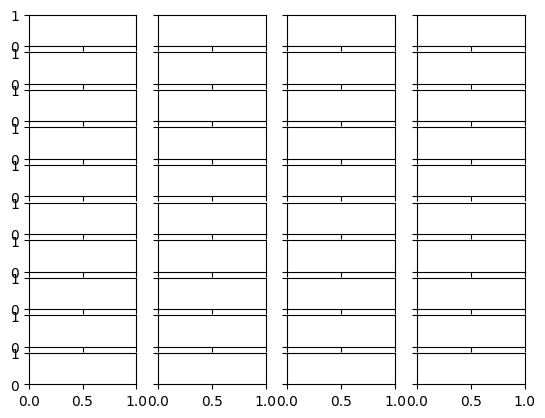

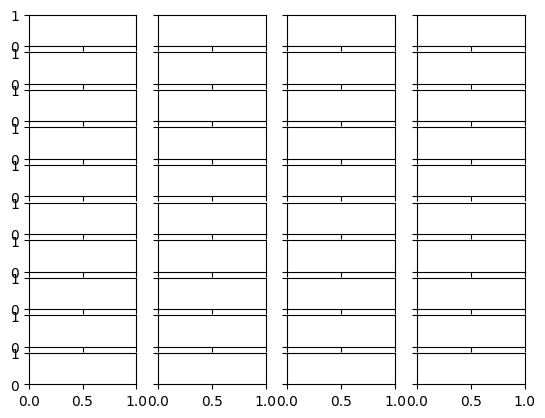

In [ ]:
# prepare to load image data
new_test = False
if new_test:
  test_name = "op-curriculum-test"
  saver.enter_folder(test_name)

new_trial = True
if new_trial:
  trial = 73

# extract the image data
imagedata = saver.load(id=trial, filenamestarts="trial_image_batch")
image_list = imagedata.trials[0].images
print("There are", len(image_list), "images")

# how many images would we like to plot
rows = 10
cols = 4

num_images = rows * cols
if num_images > len(image_list): num_images = len(image_list)

fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True)
fig2, axs2 = plt.subplots(rows, cols, sharex=True, sharey=True)

# saturate any values above this (ignore outliers)
depth_max = 5000

# find minimum of minima & maximum of depth data
dmin = 1e10
dmax = -1e10
for i in range(len(image_list)):
  this_min = np.min(image_list[i].depth[image_list[i].depth < depth_max])
  this_max = np.max(image_list[i].depth[image_list[i].depth < depth_max])
  if this_min < dmin: dmin = this_min
  if this_max > dmax: dmax = this_max

for j in range(num_images):
  ix = j // cols
  iy = j % cols
  im1 = axs[ix][iy].imshow(image_list[j].rgb, aspect="auto")
  im2 = axs2[ix][iy].imshow(image_list[j].depth, vmin=dmin, vmax=dmax, aspect='auto', cmap="viridis")

fig2.subplots_adjust(right=0.8)
cbar_ax = fig2.add_axes([0.85, 0.15, 0.05, 0.7])
fig2.colorbar(im2, cax=cbar_ax)

fig.suptitle("RGB images")
fig2.suptitle("Depth images")

fig.set_size_inches((cols * 3, rows * 2))
fig2.set_size_inches((cols * 3, rows * 2))

fig.savefig("/home/luke/gripper-ros/test_data/demo_rgb_data.png")
fig2.savefig("/home/luke/gripper-ros/test_data/demo_depth_data.png")
plt.show()


In [ ]:
im2.get_size()

image_list[-1].rgb.shape

(360, 640, 3)